# Lab 1: Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [5]:
# following lines are for colab developing
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/college/大四上/ECE365DataScienceAndEngineering/code/lab6

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/college/大四上/ECE365DataScienceAndEngineering/code/lab6


In [6]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [7]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0, 0.5, 'Net demand of Texas (in MW)')

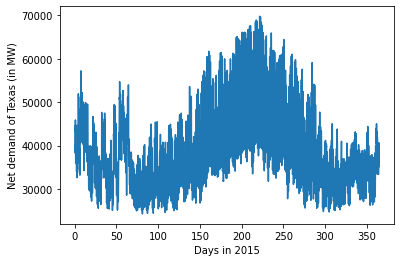

In [ ]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (10 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**Your answer.**
* The demand in the summer is higher than in the winter. Therefore, I think that the summer can be really hot in Texas. And it's just a little bit cold in winter.  
In addition, look at the profiles in winter, we can find that the demands in January and February are higher than in December. From this point, I may guess January and February are colder.


#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


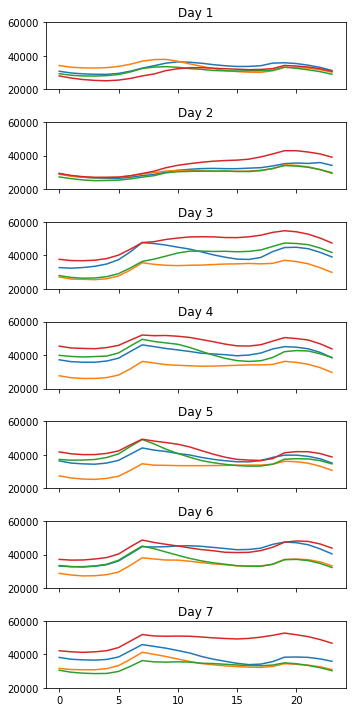

In [ ]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30 # 30(Jan31)
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):
        # winter
        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())

    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000) # winter
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (15 points).** Can you find any discernible change in the load profiles of different days of the week? Redo the above exercise for the months of August and September. Make 'Day 1' correspond to August 15th. What do you observe differently? 


**Your answer.**  
* In January and February, the weekend is different from weekdays.  
And the weekend has a lower power load.  
* In August and September, there is no discernible change.

The first day in the first plot is August 15, 2015.
Day 1  was a  Saturday.


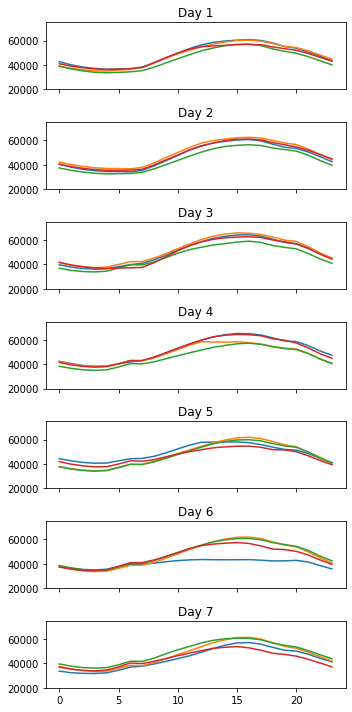

In [ ]:
# Modify the following code

# Plot the load data of the same day of the week over several weeks.

dayStart = 226
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is August 15, " + str(year) + ".")
print("Day 1", " was a ", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=75000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [ ]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [ ]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

**Question (25 points). Insert code to design the NN and its optimizer (use the relu function)** 

In [ ]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = tf.keras.layers.Input(shape=(nDimX,))
nn_layer1 = tf.keras.layers.Dense(nHidden, activation='relu')(inputs)
outputs = tf.keras.layers.Dense(nDimY)(nn_layer1)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
model.compile(
    optimizer= tf.keras.optimizers.Adagrad(1),
    loss= tf.keras.losses.MeanSquaredError(), 
    metrics = ['accuracy']
)



### Train the neural network via Keras.

Create the training module for the NN. 

Keras is a user-friendly framework to define, train and test neural networks. Check their page out for more details. https://keras.io/ 

Feed the training data in batches of size 'batchSize'.Usually, going through the training data once does not train your NN. You train over the same data multiple times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn a material by reading through it once!

**Question (20 points). Insert code to define the training module**

In [ ]:
batchSize = 8
nEpochs = 10000

# Train the model

print("Fit model on training data")

history = model.fit(
    # insert code
    trainX, trainY,
    batch_size = batchSize,
    epochs = nEpochs
    , validation_data=(testX, testY)
)


串流輸出內容已截斷至最後 5000 行。
36/36 [==============================] - 0s 3ms/step - loss: 1780820.8750 - accuracy: 0.5420 - val_loss: 5258159.0000 - val_accuracy: 0.4861
Epoch 7502/10000
36/36 [==============================] - 0s 3ms/step - loss: 1785728.3750 - accuracy: 0.5385 - val_loss: 5271731.5000 - val_accuracy: 0.5139
Epoch 7503/10000
36/36 [==============================] - 0s 2ms/step - loss: 1784631.6250 - accuracy: 0.5524 - val_loss: 5281586.5000 - val_accuracy: 0.4722
Epoch 7504/10000
36/36 [==============================] - 0s 3ms/step - loss: 1792856.8750 - accuracy: 0.5420 - val_loss: 5252977.5000 - val_accuracy: 0.4861
Epoch 7505/10000
36/36 [==============================] - 0s 3ms/step - loss: 1790562.8750 - accuracy: 0.5420 - val_loss: 5252357.0000 - val_accuracy: 0.4861
Epoch 7506/10000
36/36 [==============================] - 0s 4ms/step - loss: 1769025.5000 - accuracy: 0.5490 - val_loss: 5290790.5000 - val_accuracy: 0.4861
Epoch 7507/10000
36/36 [========================

In [ ]:
for idx in [9, 99, 999, 4999, 9999]:
    print(history.history['loss'][idx], history.history['accuracy'][idx], history.history['val_loss'][idx], history.history['val_accuracy'][idx])

55625408.0 0.42657342553138733 60781924.0 0.4444444477558136
7382965.0 0.4720279574394226 9054738.0 0.5138888955116272
3254226.5 0.5069929957389832 5517186.0 0.4722222089767456
2157102.25 0.5349650382995605 5274346.0 0.4722222089767456
1465672.0 0.5524475574493408 5320637.0 0.4861111044883728


### Let us visualize the results.

**Question (5 points). Usine the NN to predict on test data**


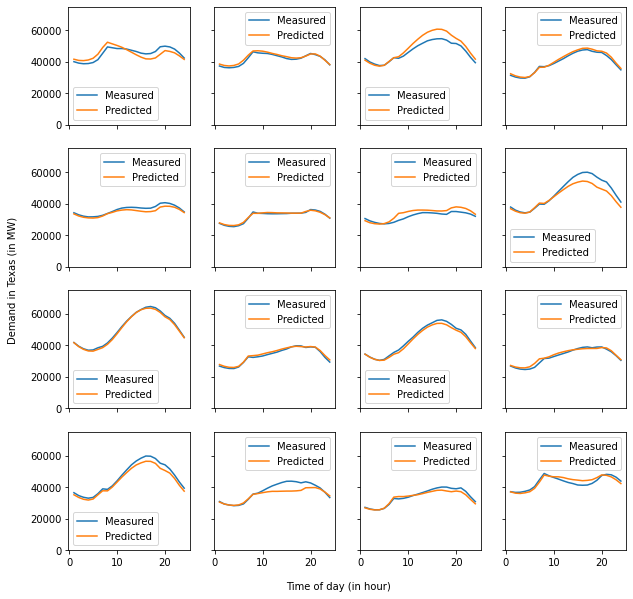

In [ ]:
# Output the accuracy of the regressor on the test data.

predictedY = model.predict(testX)

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

**Question (10 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**Your answer.**
## With only one hidden layer  
| epoch | loss | accuracy | val_loss | val_accuracy|
|------:|-------:|-----------:|-----------:|-------------:|
| 10 | 55625408.0 | 0.427 | 60781924.0  | 0.444 |  
| 100 | 7382965.0 | 0.472 | 9054738.0  | 0.514 |
| 1000 | 3254226.5 | 0.507 | 5517186.0  | 0.472 |
| 5000 | 2157102.25 | 0.535 | 5274346.0 | 0.472 |
| 10000 | 1465672.0 | 0.552 | 5320637.0 | 0.486 |

  
## With two hidden layers
| epoch | loss | accuracy | val_loss | val_accuracy|  
|------:|-------:|-----------:|-----------:|-------------:|
|10|33799472.0| 0.462 |28682300.0 |0.472|
|100|5381316.0 |0.472 |8587247.0 |0.444|
|1000|1070557.5| 0.535 |6915234.5 |0.458|

*  First, I change the learning rate to 1. Since if I use default learning rate, the training can be really slow. In addition, I use colab as the developing environment, and the each epoch costs about 3~5 ms/step(without overhead). Plus, from the history plot, I find that the val_loss decreasing slowly after about 1000 epoch. Therefore, I would favor 1000 epochs.



**Question (15 points).** Fix the number of epochs to your favorite one. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. 

**Your answer (comments here, code below). Your code should show the results for the case with an additional hidden layer. Go back to the codes above for the 1 layer case and run it again for the same number of epochs/neurons**
* After adding another hidden layer and fix the number of epoch to 1000, the val_loss is still higher than one hidden layer model. Because the model is more complex than one hidden layer model, maybe it should be trained with more epochs to get a better result. However, it may also be more possible to become overfitting.

In [ ]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = tf.keras.layers.Input(shape=(nDimX,))
nn_layer1 = tf.keras.layers.Dense(nHidden, activation='relu')(inputs)
nn_layer2 = tf.keras.layers.Dense(nHidden, activation='relu')(nn_layer1)
outputs = tf.keras.layers.Dense(nDimY)(nn_layer2)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
model.compile(
    optimizer= tf.keras.optimizers.Adagrad(1),
    loss= tf.keras.losses.MeanSquaredError(), 
    metrics = ['accuracy']
)

batchSize = 8
nEpochs = 1000

# Train the model

print("Fit model on training data")

history = model.fit(
    # insert code
    trainX, trainY,
    batch_size = batchSize,
    epochs = nEpochs
    , validation_data=(testX, testY)
)

Fit model on training data
Epoch 1/1000
36/36 [==============================] - 1s 7ms/step - loss: 1559026688.0000 - accuracy: 0.2692 - val_loss: 116560632.0000 - val_accuracy: 0.4028
Epoch 2/1000
36/36 [==============================] - 0s 3ms/step - loss: 107450968.0000 - accuracy: 0.3986 - val_loss: 96341208.0000 - val_accuracy: 0.4306
Epoch 3/1000
36/36 [==============================] - 0s 3ms/step - loss: 102828048.0000 - accuracy: 0.4406 - val_loss: 57522080.0000 - val_accuracy: 0.4722
Epoch 4/1000
36/36 [==============================] - 0s 3ms/step - loss: 72520048.0000 - accuracy: 0.4161 - val_loss: 52041920.0000 - val_accuracy: 0.4583
Epoch 5/1000
36/36 [==============================] - 0s 3ms/step - loss: 63335360.0000 - accuracy: 0.4301 - val_loss: 56082108.0000 - val_accuracy: 0.4722
Epoch 6/1000
36/36 [==============================] - 0s 4ms/step - loss: 51540864.0000 - accuracy: 0.4406 - val_loss: 58098412.0000 - val_accuracy: 0.5139
Epoch 7/1000
36/36 [============

In [ ]:
for idx in [9, 99, 999]:
    print(history.history['loss'][idx], history.history['accuracy'][idx], history.history['val_loss'][idx], history.history['val_accuracy'][idx])

33799472.0 0.4615384638309479 28682300.0 0.4722222089767456
5381316.0 0.4720279574394226 8587247.0 0.4444444477558136
1070557.5 0.5349650382995605 6915234.5 0.4583333432674408


### The effect of wind energy (bonus).

In [8]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
...,...,...,...,...,...,...,...,...,...
8755,12/31/15 19:00,31-Dec,39909,3825,16170,9.6,23.7,484.0,14.5
8756,12/31/15 20:00,31-Dec,38737,4626,16170,11.9,28.6,801.0,20.9
8757,12/31/15 21:00,31-Dec,37588,4958,16170,13.2,30.7,332.0,7.2
8758,12/31/15 22:00,31-Dec,36356,4699,16170,12.9,29.1,-259.0,-5.2


Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why?

**Your answer (comments here, code below).**
* I use the model with one hidden layer.
* The validation loss is higher and the accuracy is lower.
* The wind output is dependent on the weather. However, the weather, especially the wind, is hard to predict. Therefore, if we subtract the wind data from the load, the data may become more complex, thereby making it more difficult to be predicted.

## Load subtract Wind
| epoch | loss | accuracy | val_loss | val_accuracy|  
|------:|-------:|-----------:|-----------:|-------------:|
|10|  61827772.0| 0.339| 56569812.0| 0.333|
|100| 9046433.0| 0.367| 16172741.0| 0.431|
|1000|5268267.0| 0.42 |12991705.0 |0.403|

In [9]:
dfDemand['ERCOT Load, MW'] -= dfDemand['Total Wind Output, MW']
dfDemand[:]
# redo the experiment
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]
# 
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))
# 
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = tf.keras.layers.Input(shape=(nDimX,))
nn_layer1 = tf.keras.layers.Dense(nHidden, activation='relu')(inputs)
outputs = tf.keras.layers.Dense(nDimY)(nn_layer1)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
model.compile(
    optimizer= tf.keras.optimizers.Adagrad(1),
    loss= tf.keras.losses.MeanSquaredError(), 
    metrics = ['accuracy']
)

batchSize = 8
nEpochs = 1000

# Train the model

print("Fit model on training data")

history = model.fit(
    # insert code
    trainX, trainY,
    batch_size = batchSize,
    epochs = nEpochs
    , validation_data=(testX, testY)
)

Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.
Fit model on training data
Epoch 1/1000
36/36 [==============================] - 1s 6ms/step - loss: 349740704.0000 - accuracy: 0.2168 - val_loss: 236489392.0000 - val_accuracy: 0.2917
Epoch 2/1000
36/36 [==============================] - 0s 2ms/step - loss: 196672192.0000 - accuracy: 0.2552 - val_loss: 164979232.0000 - val_accuracy: 0.3056
Epoch 3/1000
36/36 [==============================] - 0s 2ms/step - loss: 155364352.0000 - accuracy: 0.2902 - val_loss: 138782464.0000 - val_accuracy: 0.3056
Epoch 4/1000
36/36 [==============================] - 0s 2ms/step - loss: 124758760.0000 - accuracy: 0.2867 - val_loss: 104865400.0000 - val_accuracy: 0.3056
Epoch 5/1000
36/36 [==============================] - 0s 2ms/step - loss: 108171784.0000 - accuracy: 0.3007 - val_loss: 94154944.0000 - val_accuracy: 0.3194
Epoch 6/1000
36/36 [==============================] - 0s 2ms/step - loss

In [10]:
for idx in [9, 99, 999]:
    print(history.history['loss'][idx], history.history['accuracy'][idx], history.history['val_loss'][idx], history.history['val_accuracy'][idx])

61827772.0 0.33916082978248596 56569812.0 0.3333333432674408
9046433.0 0.36713287234306335 16172741.0 0.4305555522441864
5268267.0 0.4195804297924042 12991705.0 0.4027777910232544
